# Feature Selection

This notebook compares features extracted from twitter threads against one another. For a look into the Twitter data itself, see the [Exploratory Data Analysis](./exploratory_data_analysis.ipynb)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lib.util import fetch_thread

In [2]:
Z, y = fetch_thread("germanwings-crash")
Z.describe()

,favorite_count_mean,favorite_count_sum,favorite_count_var,user_mentions_mean,user_mentions_sum,user_mentions_var,media_count_mean,media_count_sum,media_count_var,sensitive_mean,...,created,src.created_at,src.tweets_total,first_resp,last_resp,resp_var,component_count,largest_cc_diameter,time_to_first_resp,time_to_last_resp
count,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,...,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02
mean,4.798631e-16,-2.535695e-17,-4.797260e-18,2.456197e-16,-5.263280e-17,1.748944e-16,-7.319248e-16,8.278700e-17,-5.756712e-16,8.539123e-17,...,1.167455e-12,1.790474e-15,-9.375217e-17,4.124152e-13,-3.996101e-13,9.848089e-17,3.528042e-16,-3.772017e-16,-1.699601e-17,-1.112964e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.004530e-01,-4.164179e-01,-1.608630e-01,-2.013617e+00,-7.834236e-01,-8.595646e-01,-7.377092e-01,-6.853851e-01,-8.290427e-01,-1.954637e-01,...,-6.262043e-01,-1.351978e+00,-9.986559e-01,-6.394830e-01,-7.303974e-01,-2.341164e-01,-1.682398e+00,-1.096450e+00,-1.161921e-01,-4.846707e-01
25%,-3.813547e-01,-3.644712e-01,-1.596798e-01,-6.164995e-01,-6.422190e-01,-4.743147e-01,-7.377092e-01,-6.853851e-01,-8.290427e-01,-1.954637e-01,...,-5.972268e-01,-6.506988e-01,-7.932471e-01,-6.040732e-01,-6.726064e-01,-2.340749e-01,-5.136652e-01,-3.960364e-01,-1.129378e-01,-4.557384e-01
50%,-2.629071e-01,-2.822223e-01,-1.555286e-01,-2.394995e-01,-3.127418e-01,-2.875268e-01,-4.292930e-01,-1.825210e-01,-4.795957e-01,-1.954637e-01,...,-5.691532e-01,-2.159354e-01,-2.830801e-01,-5.656328e-01,-5.751977e-01,-2.326118e-01,-5.136652e-01,-3.960364e-01,-1.090147e-01,-3.903084e-01
75%,-6.506063e-02,-1.047378e-01,-1.384019e-01,4.257945e-01,3.462125e-01,3.935190e-02,4.398801e-01,3.203430e-01,7.434684e-01,-1.954637e-01,...,8.221633e-01,4.621539e-01,6.640220e-01,7.782767e-01,5.762397e-01,-2.099105e-01,6.550674e-01,3.043773e-01,-9.220795e-02,-4.945117e-02
max,1.265699e+01,1.064390e+01,1.272865e+01,7.559225e+00,7.924188e+00,1.031268e+01,3.580118e+00,5.851848e+00,2.840150e+00,1.079250e+01,...,2.537289e+00,2.571983e+00,6.646507e+00,3.898232e+00,4.613243e+00,9.886730e+00,6.498730e+00,5.907687e+00,1.898264e+01,8.028642e+00


## Univariate Feature Selection

### Pearson Correlation

For each potentially useful feature $X$, calculate the correlation coefficient between the values of that feature and response variable $Y$, which is 0 if this thread is non-rumor and 1 if rumor.

$$\rho = \frac{cov(X,Y)}{\sigma_X \sigma_Y}$$

* $cov$ is the covariance
* $\sigma_X$ is the standard deviation of feature X
* $\sigma_Y$ is the standard deviation of response variable Y

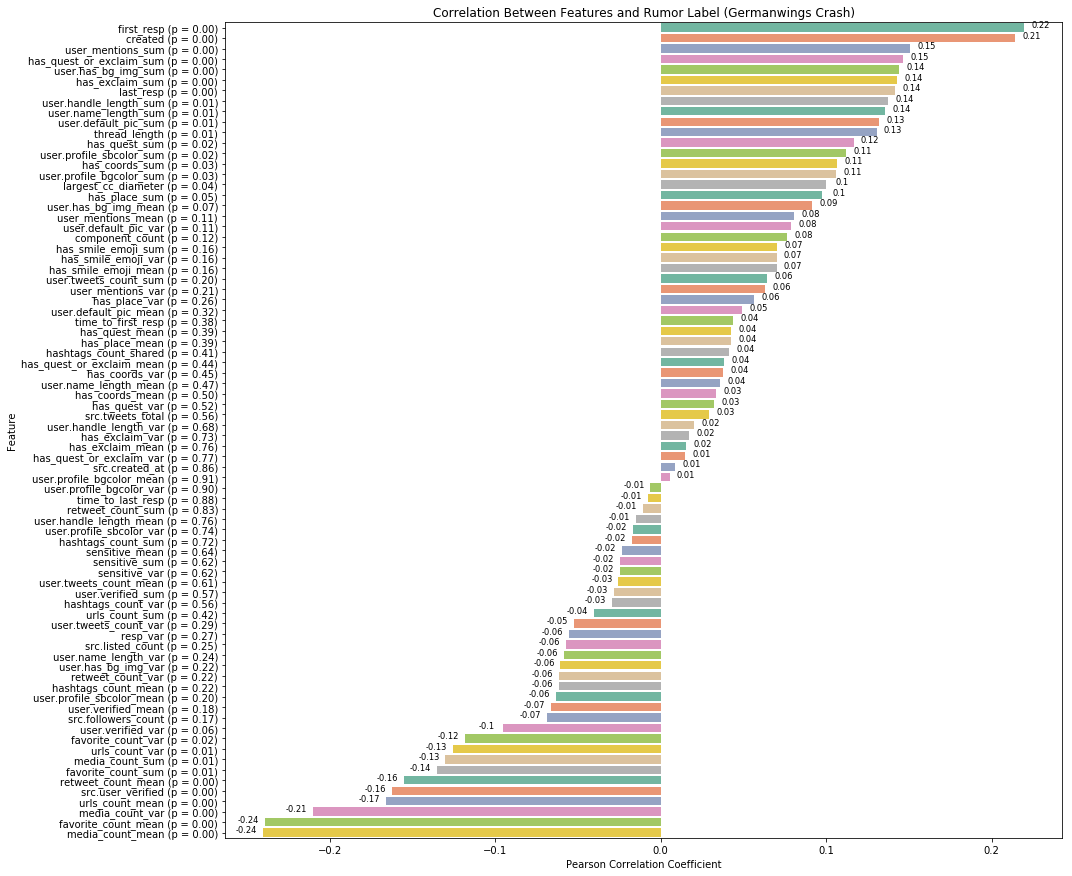

In [3]:
from scipy.stats import pearsonr

corr = Z.apply(lambda x: pearsonr(x, y), axis=0, result_type='expand')\
    .T \
    .rename(columns={0: "coef", 1: "pval"}) \
    .sort_values(by=["coef"], ascending=False)

plt.figure(figsize=(15,15))
plt.title("Correlation Between Features and Rumor Label (Germanwings Crash)")

labels = [index + " (p = %.2f)" % round(row.pval, 2) for index, row in corr.iterrows()]
ax = sns.barplot(y=labels, x=corr.coef, palette="Set2")
ax.set(xlabel="Pearson Correlation Coefficient", ylabel="Feature")

offset = 0.01
i = 0
for index, row in corr.iterrows():
    ax.text(row.coef + (offset if row.coef > 0 else -offset), i, round(row.coef, 2), 
            color="black",
            ha="center",
            fontsize='small')
    i += 1

The p-values for each feature rougly mean the probability of an uncorrelated system creating a correlation value of this magnitude by chance. By using Pearson correlation, we're assuming that there's a linear relationship between a particular feature $X$ and the classification response variable $Y$.

The results of this test seem to support what are intuitively relevant features in rumor classification.
* If the original tweet poster is verified, `src.user_verified` negatively correlates with being classified as fake news.
* Surprisingly the time of the first response, `first_resp`, has the strongest positive correlation of all the features for this dataset.

## Regression

When all the features are on the same scale, the most important features should have the highest coefficients in the model and non-relevant features should have values close to zero. TK

## Colinearity

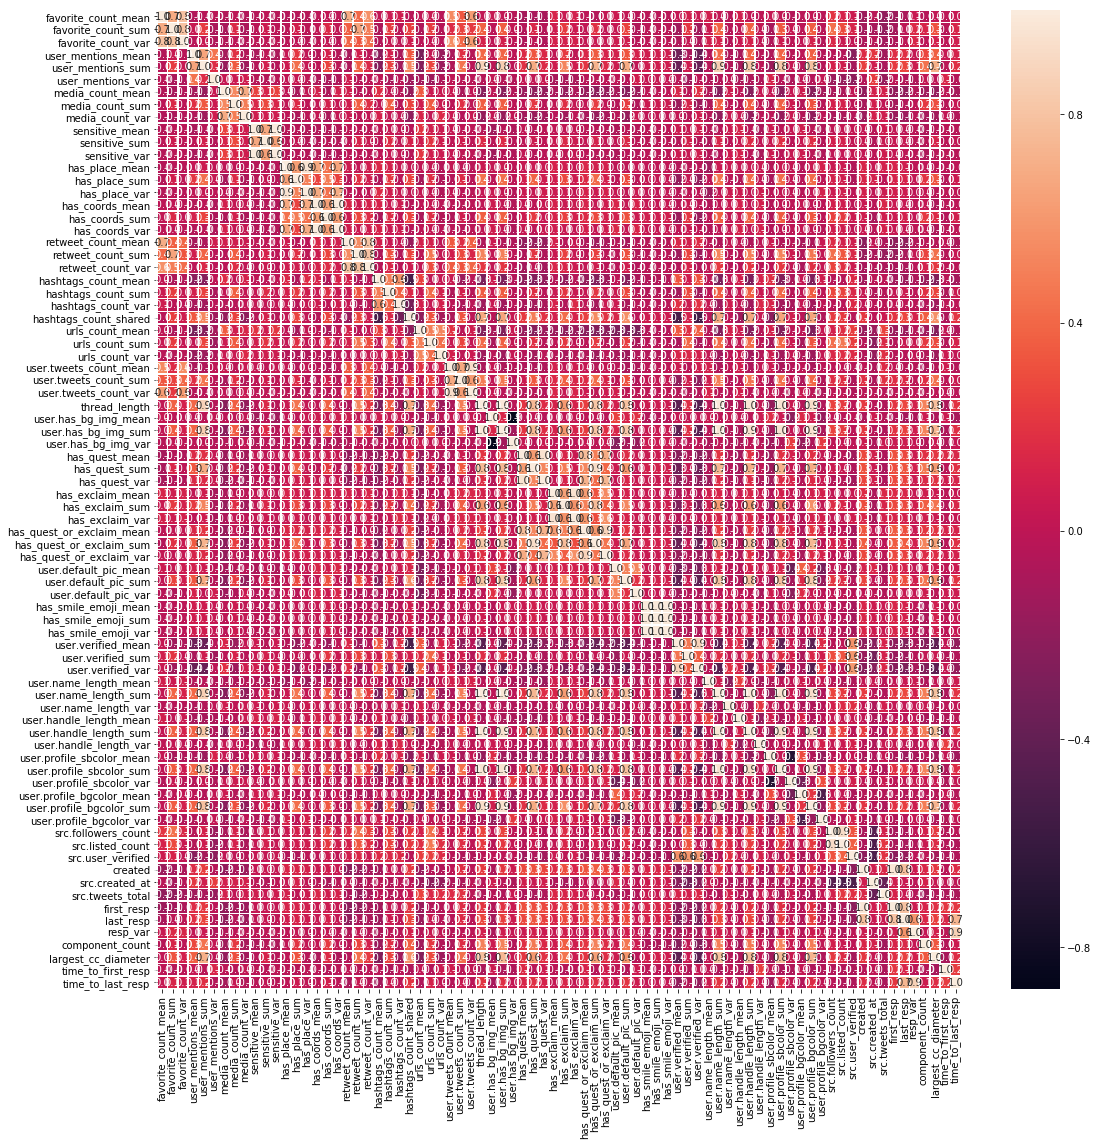

In [4]:
f, ax = plt.subplots(figsize=(18,18))
sns.heatmap(Z.corr(), annot=True, linewidth=0.5, fmt='.1f', ax=ax)